### Objective - To apply SVM on Amazon Fine Food Reviews to do semantic analysis of reviews

### Importing modules

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import random
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import validation_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#import nltk
#nltk.download('stopwords')

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import KeyedVectors
#model = KeyedVectors.load_word2vec_format(‘GoogleNews-vectors-negative300.bin.gz’,binary=True)

#import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


#### Loading our dataset 

In [3]:
con = sqlite3.connect('/Users/mohdsaquib/Documents/Data/database.sqlite') 

In [4]:
filtered_data  = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 
print(filtered_data.shape)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)

(525814, 10)
(525814, 10)


#### Sorting the data with respect to time and removing the duplicates value

In [5]:
#Sorting 40K  data according to TimeStamp in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.count()
print(type(sorted_data))

#Deduplication of entries
final2=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final = final2.head(100000) #selecting first 40K rows of data based on TimeStamp
final.shape

<class 'pandas.core.frame.DataFrame'>


(100000, 10)

#### Removing points where Helpfulness Numerator is greater than Helpfulness Denominator

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator 
ORDER BY ProductID
""", con)

display.head()
final.shape

(100000, 10)

#### Finding and removing HTML tags

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'who', "weren't", 'doing', 'up', 'over', "shan't", "won't", "you'll", 'before', 'but', 'is', 'of', 'here', 'each', 'there', "shouldn't", 'to', 'only', 'couldn', "you've", "she's", 'when', 'as', 'by', "doesn't", 'themselves', 'be', 'y', 'aren', 'yourself', 'yours', "isn't", 'i', "that'll", 'yourselves', 'she', 'did', 'again', "wouldn't", 'our', 'their', 'because', 'are', 'where', 'other', 'and', "you'd", 'm', 'should', 'or', 'me', 'has', 'in', 'under', "aren't", 'above', 'few', 'why', 'just', 'nor', "needn't", 'down', 'o', 'more', 'he', 'your', 'ain', 'whom', 'not', 'hasn', 't', 'very', 'during', 'any', 'too', 're', 'through', 'does', 'same', 'about', 'those', 'the', 'out', 'ma', 'these', 'with', 'mightn', 'until', 'needn', 'them', 'were', 'will', 'this', "hasn't", 'against', 'from', 'we', 'can', 'my', "wasn't", 'at', "mightn't", 'hers', 'was', 'theirs', 'having', 'most', 'have', 'after', 'further', 'myself', 'wouldn', 's', 'once', 'ours', 'what', "hadn't", 'had', 'which', "it's", 'did

#### Preprocessing

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 60K sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final.shape)

(100000, 11)


In [11]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [12]:
# create design matrix X and target vector y
X = np.array(final.iloc[:,:]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [13]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

### Bag of Words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train[:,9]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train[:,9])
X_cv_bow = vectorizer.transform(X_cv[:,9])
X_test_bow = vectorizer.transform(X_test[:,9])
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

After vectorizations
(49000, 42904) (49000,)
(21000, 42904) (21000,)
(30000, 42904) (30000,)
(49000,)
(21000,)
(30000,)


### Linear Kernel SVM on BOW (Train)

In [35]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(X_train_bow, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.9274132131031654  and for train data auc score is -->  0.9658684594337059
0.0001  for CV data auc score is -->  0.9271052640133091  and for train data auc score is -->  0.9650094530807768
0.001  for CV data auc score is -->  0.9354134952187482  and for train data auc score is -->  0.9600646679620443
0.01  for CV data auc score is -->  0.9058411441198319  and for train data auc score is -->  0.9222682418812408
0.1  for CV data auc score is -->  0.7367220692741743  and for train data auc score is -->  0.7512064761292476
1  for CV data auc score is -->  0.5285933937734747  and for train data auc score is -->  0.5337119720672046
10  for CV data auc score is -->  0.5286763047888479  and for train data auc score is -->  0.528152768033093
100  for CV data auc score is -->  0.5402277531589589  and for train data auc score is -->  0.5403878670052915

 Best C Value 0.001 with highest roc_auc Score is 0.9354134952187482


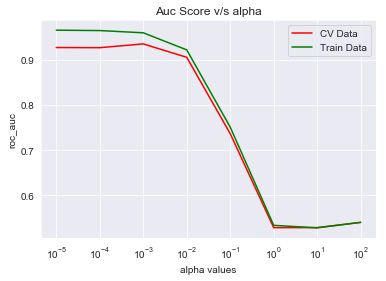

In [59]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_bow,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_bow, y_train)
    y_train_pred =  sig_clf.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv_bow)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

### Observation -
#### Best ROC_AUC score = 0.93
#### Optimal value of C = 0.001

In [64]:
optimal_alpha = 0.001

### Testing

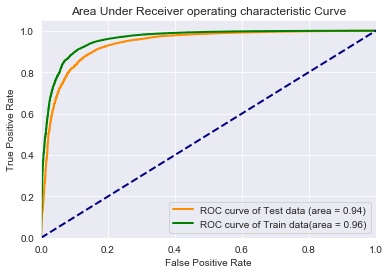

In [67]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_bow,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_bow, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(X_test_bow)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")



### Observation
#### ROC of Test data = 0.94
#### ROC of Train data = 0.96

Text(34,0.5,'True Label')

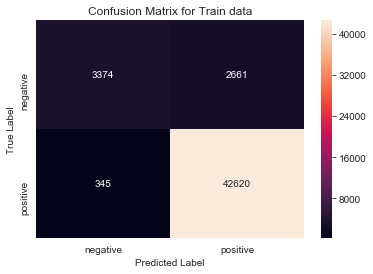

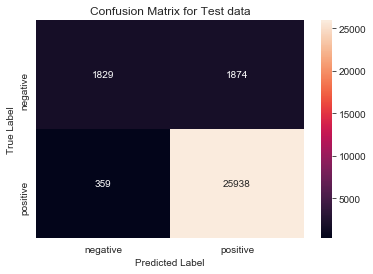

In [69]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
    

### Observation 
#### From train Confusion Matrix we can say that 3374 are correctly classified as negative points and 42620 positive points are correctly classified as positive points.
#### From test Confusion Matrix we can say that 1829 are correctly classified as negative points and 25938 positive points are correctly classified as positive points.

### Classification Report

In [72]:
prediction=sig_clf.predict(X_test_bow)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.7898393285432115
micro f1 scoore for data: 0.9255666666666666
hamming loss for data: 0.07443333333333334
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.84      0.49      0.62      3703
          1       0.93      0.99      0.96     26297

avg / total       0.92      0.93      0.92     30000



### Top 10 positive and negative features

In [92]:
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\t\t\tPositive")
print("________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative						Positive
________________________________________________________________________________________________
	-1.1135	worst          				0.7464	delicious      
	-0.9422	terrible       				0.6404	great          
	-0.8688	disappointing  				0.6077	excellent      
	-0.7586	disappointment 				0.6077	best           
	-0.7546	unfortunately  				0.5914	smooth         
	-0.7505	horrible       				0.5873	pleased        
	-0.6975	threw          				0.5629	perfect        
	-0.6934	awful          				0.5506	wonderful      
	-0.6607	return         				0.5180	yummy          
	-0.6526	disappointed   				0.4854	happy          


### Tfidf

In [109]:
#tf-idf on train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) #considering only uni-gram as I was getting memory error
train_tfidf = tf_idf_vect.fit_transform(X_train[:,9]) #sparse matrix
cv_tfidf= tf_idf_vect.transform(X_cv[:,9])
test_tfidf = tf_idf_vect.transform(X_test[:,9])
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(49000, 42779)
(21000, 42779)
(30000, 42779)


### Linear SVM on TFIDF (TRAIN)

In [110]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.9459825114334577  and for train data auc score is -->  0.9845299557960224
0.0001  for CV data auc score is -->  0.9442604699307363  and for train data auc score is -->  0.9652745484340435
0.001  for CV data auc score is -->  0.940480718156885  and for train data auc score is -->  0.9583871534176501
0.01  for CV data auc score is -->  0.93542570203509  and for train data auc score is -->  0.9517970386224849
0.1  for CV data auc score is -->  0.5660006505433306  and for train data auc score is -->  0.5622332210800831
1  for CV data auc score is -->  0.5466412446133472  and for train data auc score is -->  0.5417119687911836
10  for CV data auc score is -->  0.5466412446133472  and for train data auc score is -->  0.5417119687911836
100  for CV data auc score is -->  0.5466412446133472  and for train data auc score is -->  0.5417119687911836

 Best C Value 1e-05 with highest roc_auc Score is 0.9459825114334577


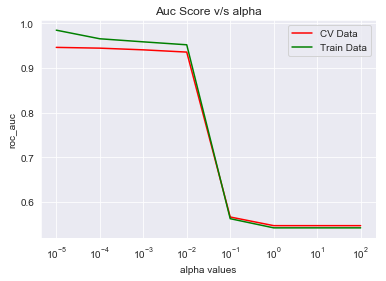

In [116]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_tfidf,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_tfidf, y_train)
    y_train_pred =  sig_clf.predict_proba(train_tfidf)[:,1]
    y_cv_pred =  sig_clf.predict_proba(cv_tfidf)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

#### The best ROC_AUC score is 0.94  for C=0.0001

In [117]:
optimal_alpha = 0.00001


### Testing

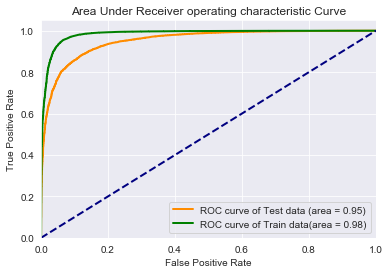

In [119]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(test_tfidf)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")



#### AUC score for Train data = 0.98
#### AUC score for test data = 0.95

Text(34,0.5,'True Label')

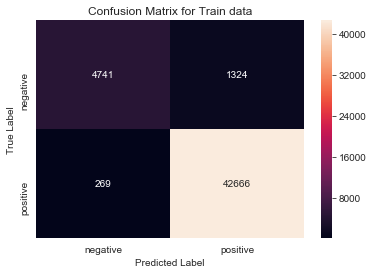

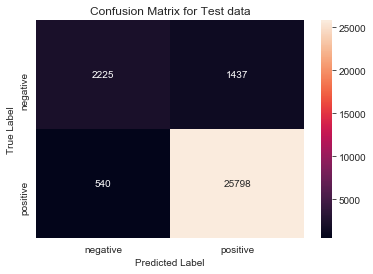

In [120]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(train_tfidf))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(test_tfidf))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From train Confusion Matrix we can say that 4741 are correctly classified as negative points and 42666 positive points are correctly classified as positive points.
#### From test Confusion Matrix we can say that 2225 are correctly classified as negative points and 25798 positive points are correctly classified as positive points.

### Classification Report 

In [121]:
prediction=sig_clf.predict(test_tfidf)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.8277442779784367
micro f1 scoore for data: 0.9341
hamming loss for data: 0.0659
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.80      0.61      0.69      3662
          1       0.95      0.98      0.96     26338

avg / total       0.93      0.93      0.93     30000



### Top 10 positive and negative features 

In [122]:
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\t\t\tPositive")
print("________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative						Positive
________________________________________________________________________________________________
	-7.8877	windy          				8.7282	gravey         
	-6.4954	dingo          				7.5698	degree         
	-5.9376	taxing         				6.8318	bergin         
	-5.2852	dings          				5.2719	pepomint       
	-5.0327	dinged         				4.8507	everlasting    
	-4.8981	hopjes         				4.7128	hiatal         
	-4.8324	windowsills    				4.6812	newbies        
	-4.7638	ukraine        				4.6332	wich           
	-4.4958	resolving      				4.5734	goldenberries  
	-4.3531	awful          				4.4735	loooking       


### Avg w2v

In [126]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [127]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [128]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors[0]))
print(type(sent_vectors))

100000
<class 'list'>


In [129]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [130]:
# split the data set into train and test
X_1, X_test_avgw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train_avgw2v, X_cv_avgw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

### Linear SVM on AVG-W2V (Train)

In [132]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(X_train_avgw2v, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.8749085419513913  and for train data auc score is -->  0.8758754918505696
0.0001  for CV data auc score is -->  0.8891544377524202  and for train data auc score is -->  0.8913713361597164
0.001  for CV data auc score is -->  0.8966704748845001  and for train data auc score is -->  0.8981273591449667
0.01  for CV data auc score is -->  0.896947470515956  and for train data auc score is -->  0.8979079938149913
0.1  for CV data auc score is -->  0.8968052636053716  and for train data auc score is -->  0.8978336452661254
1  for CV data auc score is -->  0.8847085905266383  and for train data auc score is -->  0.8868877490931644
10  for CV data auc score is -->  0.618454519153691  and for train data auc score is -->  0.620994483466889
100  for CV data auc score is -->  0.6184802797260384  and for train data auc score is -->  0.6210459694427963

 Best C Value 0.01 with highest roc_auc Score is 0.896947470515956


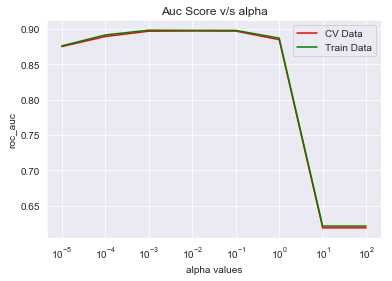

In [133]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_avgw2v,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_avgw2v, y_train)
    y_train_pred =  sig_clf.predict_proba(X_train_avgw2v)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv_avgw2v)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

### Observation 
#### The best ROC_AUC score = 0.89
#### For C = 0.01


In [134]:
optimal_alpha= 0.01

### Testing

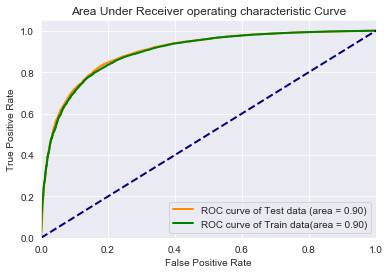

In [135]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_avgw2v,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_avgw2v, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(X_test_avgw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")


### Observation 
#### The AUC score for train data = .90
#### The AUC score for test data = 0.90

Text(34,0.5,'True Label')

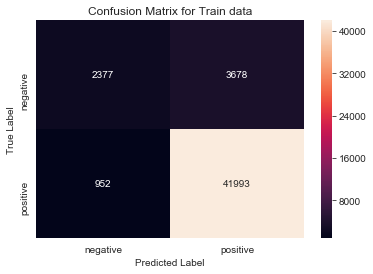

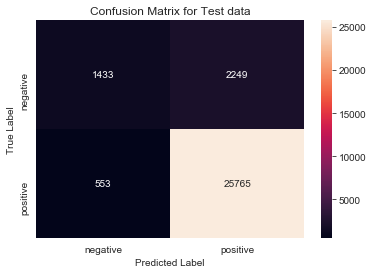

In [138]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From train Confusion Matrix we can say that 2377 are correctly classified as negative points and 41993 positive points are correctly classified as positive points.
#### From test Confusion Matrix we can say that 1433 are correctly classified as negative points and 25765 positive points are correctly classified as positive points.

#### Classification Report

In [145]:
prediction=sig_clf.predict(X_test_avgw2v)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.7270369563515273
micro f1 scoore for data: 0.9066
hamming loss for data: 0.0934
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.39      0.51      3682
          1       0.92      0.98      0.95     26318

avg / total       0.90      0.91      0.89     30000



### TFIDF W2V

In [147]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])


<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [148]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [149]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [150]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [151]:

print(len(tfidf_sent_vectors))
print(np.shape(tfidf_sent_vectors))
print(type(tfidf_sent_vectors))

100000
(100000, 50)
<class 'list'>


In [152]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [153]:
# split the data set into train and test
X_1, X_test_tfidfw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
train_tfidfw2v, cv_tfidfw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

### Linear SVM on TFIDF-W2V (train)

In [154]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(train_tfidfw2v, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.8827157301168425  and for train data auc score is -->  0.8768645647330267
0.0001  for CV data auc score is -->  0.8975277178264118  and for train data auc score is -->  0.8925421780612406
0.001  for CV data auc score is -->  0.9000453440620909  and for train data auc score is -->  0.8957862574139854
0.01  for CV data auc score is -->  0.9013044242238768  and for train data auc score is -->  0.8963381653936805
0.1  for CV data auc score is -->  0.9009152023311868  and for train data auc score is -->  0.8960176830896627
1  for CV data auc score is -->  0.901409660902256  and for train data auc score is -->  0.8963272213261402
10  for CV data auc score is -->  0.7195424575840748  and for train data auc score is -->  0.7178989986124346
100  for CV data auc score is -->  0.6174640545496011  and for train data auc score is -->  0.6209057594188291

 Best C Value 1 with highest roc_auc Score is 0.901409660902256


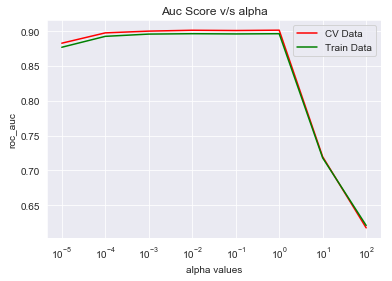

In [155]:
## Linear SVM
best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_tfidfw2v,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_tfidfw2v, y_train)
    y_train_pred =  sig_clf.predict_proba(train_tfidfw2v)[:,1]
    y_cv_pred =  sig_clf.predict_proba(cv_tfidfw2v)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

### Observation
#### The best ROC_AUC score = 0.90
#### For C=1

In [156]:
optimal_alpha = 1

### Testing

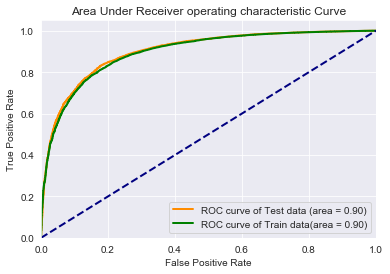

In [158]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_tfidfw2v,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidfw2v, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(X_test_tfidfw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

### Observation 
#### The AUC score for train data = 0.90
#### The AUC score for test data = 0.90

Text(34,0.5,'True Label')

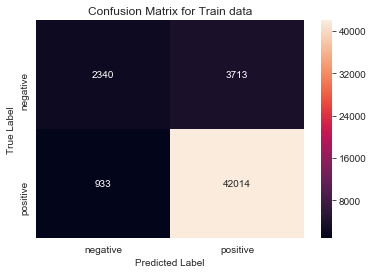

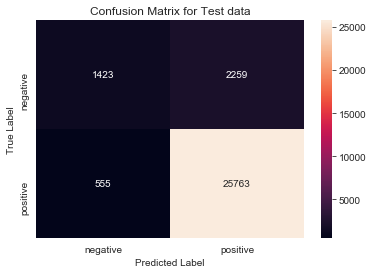

In [159]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(train_tfidfw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(X_test_tfidfw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From train Confusion Matrix we can say that 2340 are correctly classified as negative points and 42014 positive points are correctly classified as positive points.
#### From test Confusion Matrix we can say that 1423 are correctly classified as negative points and 25763 positive points are correctly classified as positive points.

### Classification Report

In [160]:
prediction=sig_clf.predict(X_test_tfidfw2v)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.72552089903773
micro f1 scoore for data: 0.9062
hamming loss for data: 0.0938
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.39      0.50      3682
          1       0.92      0.98      0.95     26318

avg / total       0.89      0.91      0.89     30000



#### *Now Taking only 20k points for RBF Kernel as it takes lot of time to run. *

In [233]:
#data splitting for RBF kernel
y_train=final['Score'][0:13000]
y_cv=final['Score'][13000:16000]
y_test=final['Score'][16000:20000]

In [234]:
X_train=final['CleanedText'][0:13000]
X_cv=final['CleanedText'][13000:16000]
X_test=final['CleanedText'][16000:20000]

In [235]:
print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(13000,)     (13000,)
(3000,)     (3000,)
(4000,)     (4000,)


### Bag of Words 

In [237]:
cnt_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
X_train_bow = cnt_vec.fit_transform(X_train)
X_cv_bow  = cnt_vec.transform(X_cv)
X_test_bow = cnt_vec.transform(X_test)

In [238]:

print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)


(13000, 300)
(3000, 300)
(4000, 300)


### RBF SVC for BOW (TRAIN)

------------------------------ AUC Score for train data ------------------------------


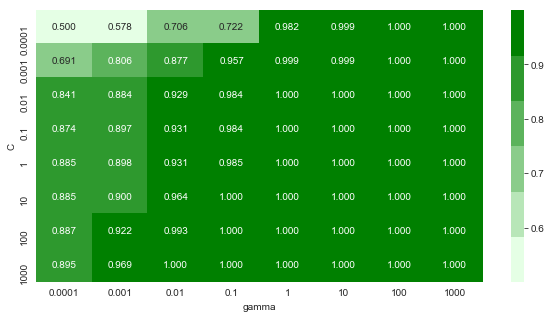

------------------------------ AUC Score for CV data ------------------------------


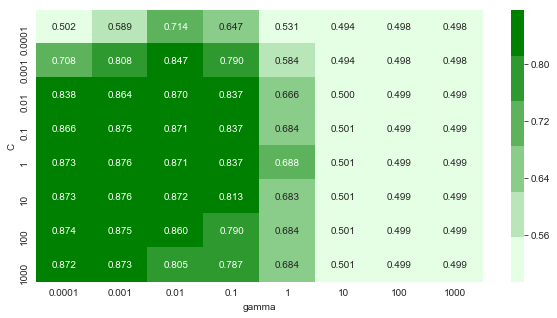

In [239]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(X_train_bow,y_train)
        probs = clf.predict_proba(X_cv_bow)
        prob = clf.predict_proba(X_train_bow)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

### Observations
#### Optimal C = 0.01
#### Gamma = 0.1

### Testing

AUC Score 0.8157341076033132
macro f1 score for data : 0.6301654465752232
micro f1 scoore for data: 0.898
hamming loss for data: 0.102
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.60      0.21      0.32       439
          1       0.91      0.98      0.94      3561

avg / total       0.88      0.90      0.88      4000



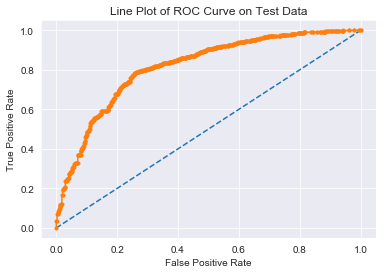

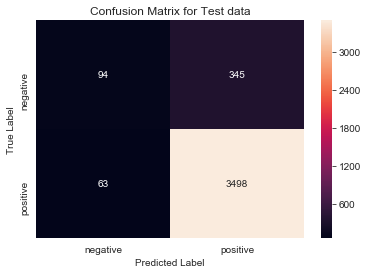

In [267]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=0.01,kernel='rbf',probability=True,gamma=0.1)
clf.fit(X_train_bow,y_train)
prob = clf.predict_proba(X_test_bow) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


### TFIDF

In [240]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
tf_train = tfidf_vec.fit_transform(X_train)
tf_cv  = tfidf_vec.transform(X_cv)
tf_test = tfidf_vec.transform(X_test)

In [241]:
print(tf_train.shape)
print(tf_cv.shape)
print(tf_test.shape)

(13000, 300)
(3000, 300)
(4000, 300)


In [242]:
y_train.shape

(13000,)

### RBF_SVC ON TFIDF(TRAIN)

------------------------------ AUC Score for train data ------------------------------


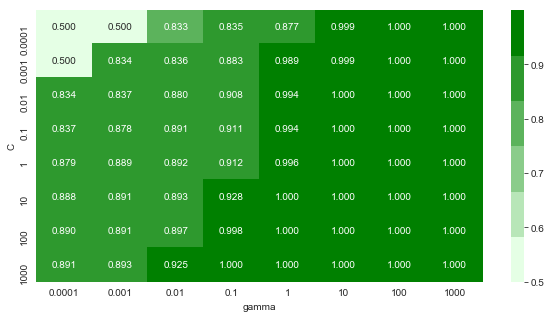

------------------------------ AUC Score for CV data ------------------------------


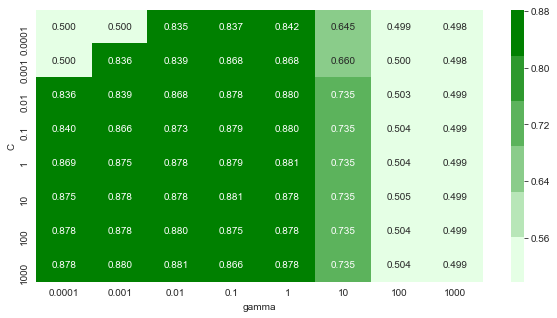

In [243]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(tf_train,y_train)
        probs = clf.predict_proba(tf_cv)
        prob = clf.predict_proba(tf_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

### Observation
#### Optimal C = 1
#### Gama = 1

### Testing

AUC Score 0.8594070540191483
macro f1 score for data : 0.6809468155133733
micro f1 scoore for data: 0.905
hamming loss for data: 0.095
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.64      0.31      0.41       439
          1       0.92      0.98      0.95      3561

avg / total       0.89      0.91      0.89      4000



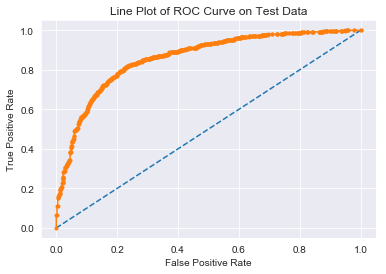

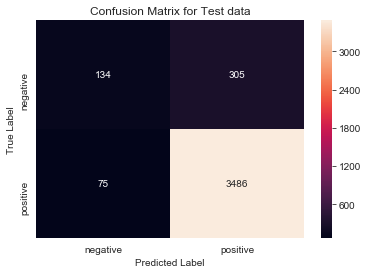

In [268]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=1,kernel='rbf',probability=True,gamma=1)
clf.fit(tf_train,y_train)
prob = clf.predict_proba(tf_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


### AVG-W2V

In [244]:
avg_w2v = np.array(sent_vectors)

In [245]:
avg_w2v.shape

(100000, 50)

In [246]:
avgw2v_train = avg_w2v[0:13000]
avgw2v_cv = avg_w2v[13000:16000]
avgw2v_test = avg_w2v[16000:20000]

In [247]:
avgw2v_train.shape

(13000, 50)

In [248]:
y_train.shape

(13000,)

### RBF SVC ON AVG-W2V (TRAIN)

------------------------------ AUC Score for train data ------------------------------


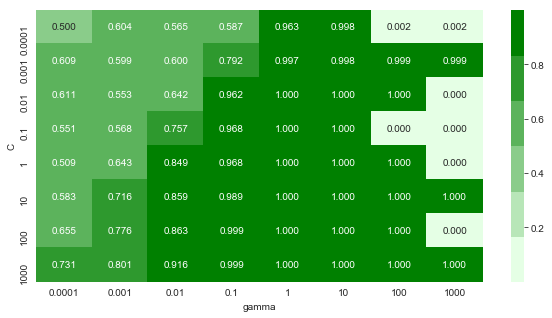

------------------------------ AUC Score for CV data ------------------------------


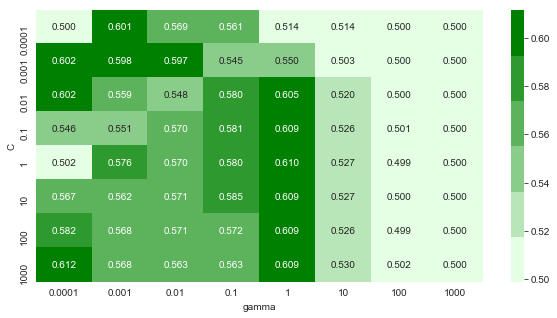

In [249]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(avgw2v_train,y_train)
        probs = clf.predict_proba(avgw2v_cv)
        prob = clf.predict_proba(avgw2v_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

### Observation
#### Optimal gamma = 1
#### Optimal C = 1

### Testing

AUC Score 0.5725494297563007
macro f1 score for data : 0.47546875499402436
micro f1 scoore for data: 0.89025
hamming loss for data: 0.10975
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.50      0.00      0.01       439
          1       0.89      1.00      0.94      3561

avg / total       0.85      0.89      0.84      4000



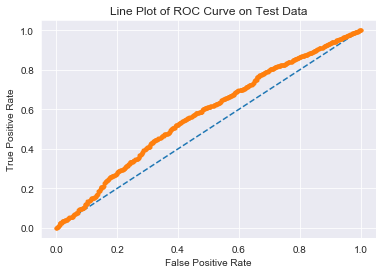

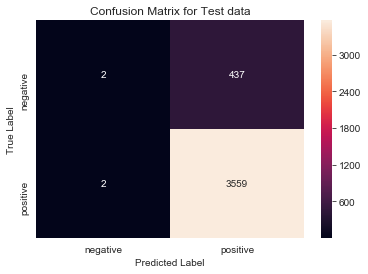

In [269]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=1,kernel='rbf',probability=True,gamma=1)
clf.fit(avgw2v_train,y_train)
prob = clf.predict_proba(avgw2v_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


### TFIDF-W2V

In [250]:
train_tfidfw2v.shape

(49000, 50)

In [253]:

tfrbf_train = train_tfidfw2v[0:13000]
tfrbf_cv = train_tfidfw2v[13000:16000]
tfrbf_test = train_tfidfw2v[16000:20000]

### RBF-SVC ON TFIDF-W2V (TRAIN)

------------------------------ AUC Score for train data ------------------------------


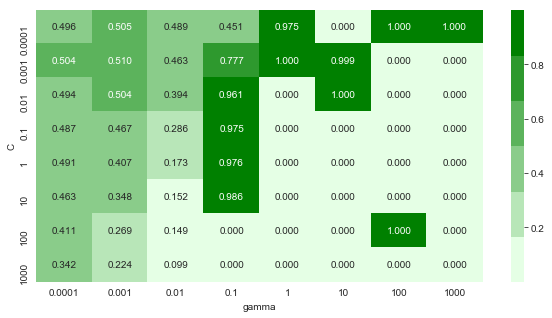

------------------------------ AUC Score for CV data ------------------------------


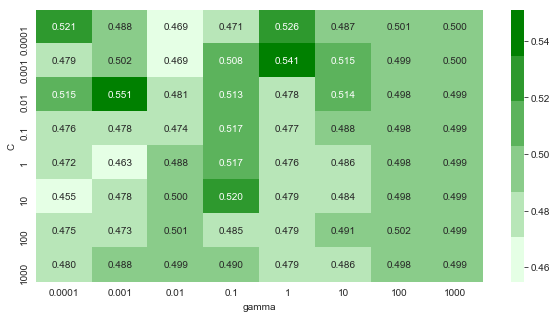

In [252]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(tfrbf_train,y_train)
        probs = clf.predict_proba(tfrbf_cv)
        prob = clf.predict_proba(tfrbf_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

### Observation 
#### optimal_gamma = 1
#### optimal_C = 0.001

### Testing

AUC Score 0.49668741152411056
macro f1 score for data : 0.47096944848565003
micro f1 scoore for data: 0.89025
hamming loss for data: 0.10975
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       439
          1       0.89      1.00      0.94      3561

avg / total       0.79      0.89      0.84      4000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


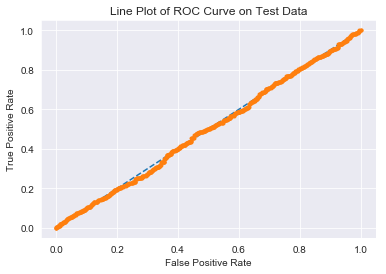

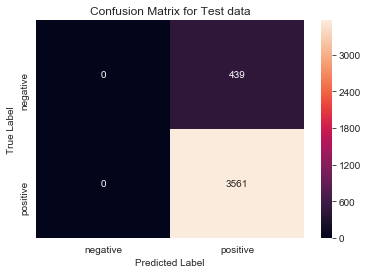

In [275]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=0.001,kernel='rbf',probability=True,gamma=1)
clf.fit(tfrbf_train,y_train)
prob = clf.predict_proba(tfrbf_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


### Conclusion

In [274]:

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","Liner kernel",0.001,0.94])
x.add_row(["Tf-Idf","Liner kernel",1e-05,0.95])
x.add_row(["Avg-W2V","Liner kernel",0.01,0.90])
x.add_row(["TfIdf-W2V","Liner kernel",1,0.90])

y = PrettyTable()
y.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C & gamma)","Test Auc Score"]
y.add_row(["BoW","RBF kernel",(0.01,0.1),0.81])
y.add_row(["Tf-Idf","RBF kernel",(1,1),0.85])
y.add_row(["Avg-W2V","RBF kernel",(1,1),0.57])
y.add_row(["TfIdf-W2V","RBF kernel",(0.001,1),0.49])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)
print(y)

****Final Conclusion:****

+------------+--------------+-------------------------+----------------+
| Vectorizer |    Model     | Best Hyper Parameter(C) | Test Auc Score |
+------------+--------------+-------------------------+----------------+
|    BoW     | Liner kernel |          0.001          |      0.94      |
|   Tf-Idf   | Liner kernel |          1e-05          |      0.95      |
|  Avg-W2V   | Liner kernel |           0.01          |      0.9       |
| TfIdf-W2V  | Liner kernel |            1            |      0.9       |
+------------+--------------+-------------------------+----------------+
+------------+------------+---------------------------------+----------------+
| Vectorizer |   Model    | Best Hyper Parameter(C & gamma) | Test Auc Score |
+------------+------------+---------------------------------+----------------+
|    BoW     | RBF kernel |           (0.01, 0.1)           |      0.81      |
|   Tf-Idf   | RBF kernel |              (1, 1)             |      0.85      |
|  Avg-W2V   | RBF ke

#### *The model Tfidf with Linear Kernel works best with an AUC score of 0.95 in testing.*